# Analysis-I: Basic Analysis done through python wrapper and compared with out C++ code.

This analysis is for comparing xpcs-eigen results to pyxpcs results. The input to analysis is specific to 8-id-i IMM file format. 

In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import h5py

from pyxpcs.structs import PyXPCSArray
from pyxpcs.config import PyXPCSDict
from pyxpcs.utils import config_from_8idhdf5, load_results
from pyxpcs.viz import plot_pix_sum, plot_as_image

import matplotlib.pyplot as plt

import libpyxpcs as libpx

from pprint import pprint

## Input Data

Specify the input IMM file to use. The result file from the xpcs-eigen analysis that contains G2, IP, and IF. The HDF5 file that will be used to run the pyxpcs analysis.

In [2]:
HDF5_FILE = "/home/faisal/Development/xpcs-eigen/data/hdf5_test/A003_Cu3Au_att0_001_multitau.hdf"
HDF5_DATA_FILE = "/home/faisal/Development/xpcs-eigen/data/hdf5_test/A003_Cu3Au_att0_001.h5"


## Configuration

Load the configuration that are specific to 8-ID-I


In [3]:
config = config_from_8idhdf5(HDF5_FILE)
try:
    import pandas as pd
    df = pd.DataFrame.from_dict(config, orient='index')
    print(df)
except:
    pass

                                                                   0
rows                                                             516
cols                                                             516
pixels                                                        266256
frame_start                                                        1
frame_end                                                      10000
frame_start_limit                                                  1
frame_end_limit                                                10000
frames                                                          9999
delays_per_level                                                   4
dqmap              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
sqmap              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
roi_1d             [198, 198, 200, 202, 204, 206, 208, 210, 212, ...
beam_center_x                                                276.428
beam_center_y                     

## Load data


In [4]:
f = h5py.File(HDF5_DATA_FILE, 'r')
paths = f["/"].keys()


In [5]:
data = f['/entry/data/data'][:]

In [6]:
data.shape

(10000, 516, 516)

In [7]:
sparse_data = libpx.sparse_lil_value(data)

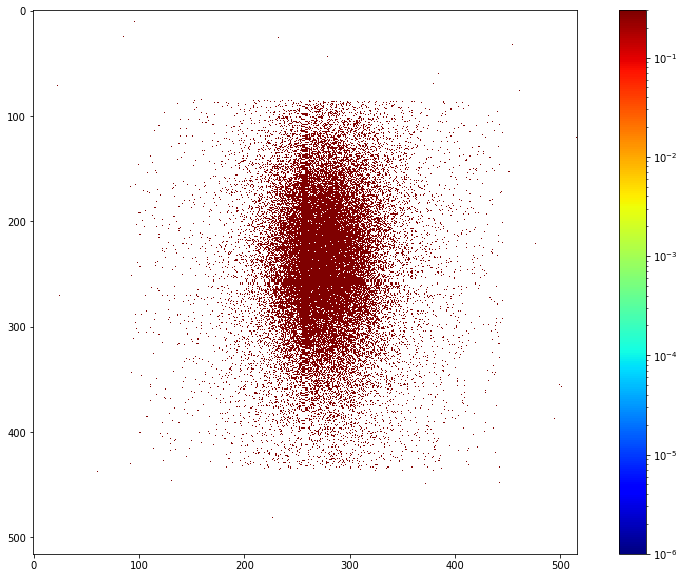

In [8]:
plot_as_image(data[0, :, :])

In [ ]:
the_frame = np.zeros(data.shape[1]*data.shape[2])                  
frame_to_plot = 0

for idx in range(data.shape[1]*data.shape[2]):
    row = sparse_data.Pixel(idx)
    for fno, value in zip(row.indxPtr, row.valPtr):
        if fno == frame_to_plot:
            the_frame[idx] = value
            break

In [ ]:
plot_as_image(the_frame.reshape(data.shape[1], data.shape[2]))

## Plotting

Basic plotting to verify the data is read properly.

In [ ]:
pixel_sum = np.zeros(config['cols'] * config['rows'])
for idx in range(len(indices)):
    pixel_sum[indices[idx]] += values[idx]

pixel_sum = np.reshape(pixel_sum, (config['cols'], config['rows']))
plot_pix_sum(pixel_sum, config)

## Analysis


In [9]:
mini_config = {
    'frames': config['frames'],
    'pixels': config['cols'] * config['rows'],
    'delays_per_level': config['delays_per_level'],
    'rows': config['rows'],
    'cols': config['cols'],  
}

G2, IP, IF = libpx.multitau(sparse_data, mini_config)

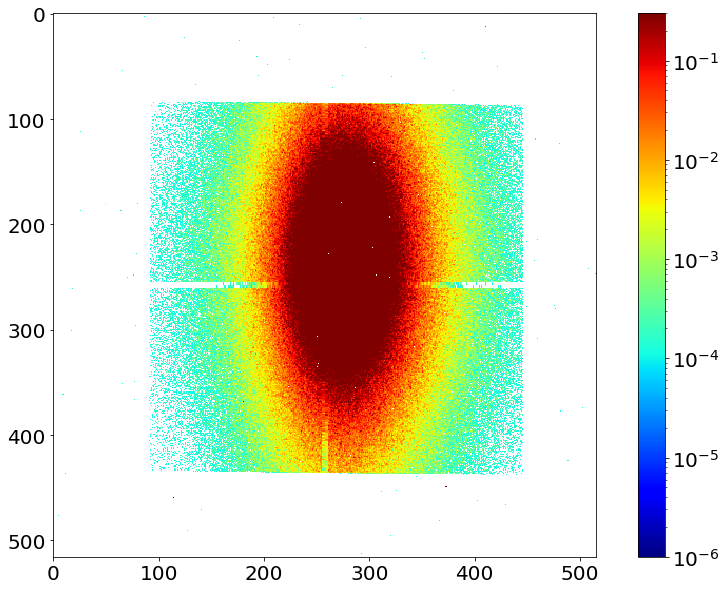

In [10]:
# In order to plot G2.
G2_plot = G2[0].reshape(config['cols'], config['rows'])
plot_as_image(G2_plot)

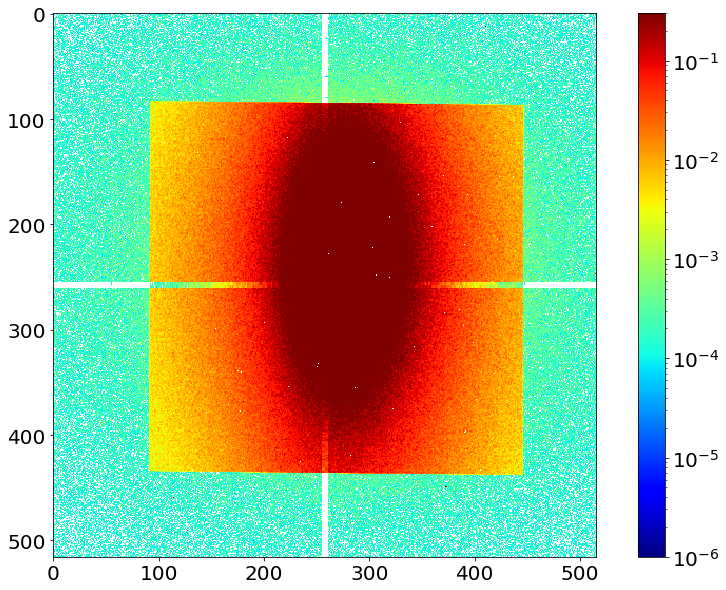

In [11]:
IP_plot = IP[0].reshape(config['cols'], config['rows'])
plot_as_image(IP_plot)

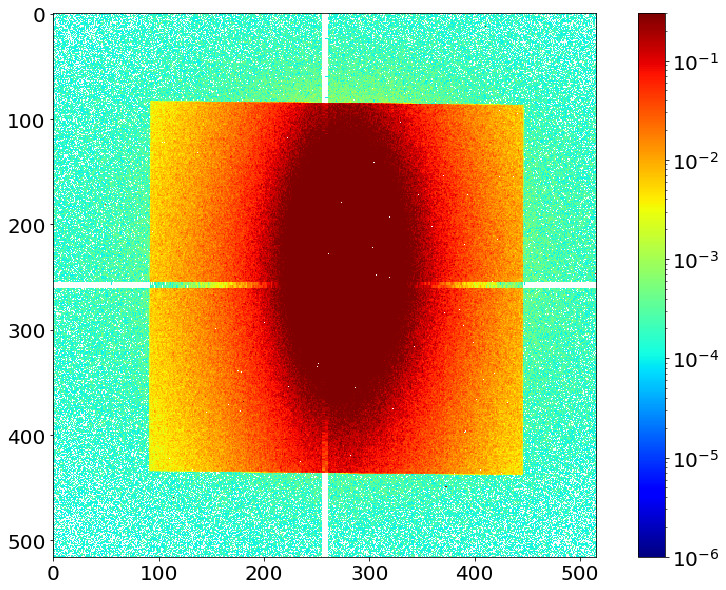

In [12]:
IF_plot = IF[0].reshape(config['cols'], config['rows'])
plot_as_image(IF_plot)

### g2 stderror

In [13]:
def compute_g2(G2, IP, IF, config):

    taus, pixels = G2.shape

    total_static_partitions = np.max(config['sqmap'])
    total_dynamic_partitions = np.max(config['dqmap'])

    # Final results
    g2 = np.zeros((taus, total_dynamic_partitions))
    g2_error = np.zeros((taus, total_dynamic_partitions))

    g2Sums = np.zeros((taus, total_static_partitions))
    ipSums = np.zeros((taus, total_static_partitions))
    ifSums = np.zeros((taus, total_static_partitions))

    dqmap = config['dqmap']
    sqmap = config['sqmap']


    IP_IF = IP * IF
    normalizedG2 = G2 /  (np.where( IP_IF != 0, IP_IF, 10000))

    # sum pixels for each static partitions
    for i in range(total_static_partitions):
        idx = (sqmap == i+1)
        g2Sums[:, i] = np.mean(G2[:, idx.flatten()], axis=1)
        ipSums[:, i] = np.mean(IP[:, idx.flatten()], axis=1)
        ifSums[:, i] = np.mean(IF[:, idx.flatten()], axis=1)

    ip_if_sums = ipSums * ifSums

    # Compute G2 error. 
    for i in range(total_dynamic_partitions):
        idx = (dqmap == i + 1)
        idx = idx.flatten()
        g2_error[:, i] = np.std(normalizedG2[:, idx], axis=1) / np.sqrt(pixels)

    for i in range(total_dynamic_partitions):
        low, high = np.amin(sqmap[dqmap == i+1]), np.max(sqmap[dqmap == i+1])
        tmp_g2_sum = g2Sums[:, low-1:high-1]
        g2[:, i] = np.mean(tmp_g2_sum / ip_if_sums[:, low-1:high-1], axis=1)
    
    return g2, g2_error

In [17]:
g2, g2_error = compute_g2(G2, IP, IF, config)
print(g2.shape)

(48, 1)


In [18]:
g2_q0 = g2[:, 0]

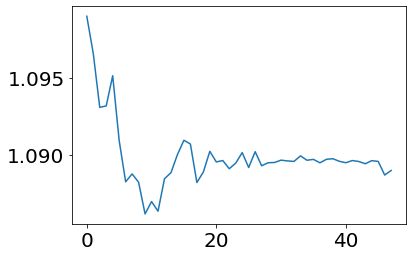

In [19]:
plt.plot(g2_q0)

## Verification

Verify the results with the C++ version directly

In [ ]:
config2 = config_from_8idhdf5(RESULT_FILE)

In [ ]:
ret = load_results(RESULT_FILE, '/exchange', ['pixelSum', 'G2', 'IP', 'IF'])

pixel_sum_computed = ret['pixelSum']
G2_computed = ret['G2']
IP_computed = ret['IP']
IF_computed = ret['IF']

In [ ]:
plot_pix_sum(pixel_sum_computed, config2)

In [ ]:
plot_as_image(G2_computed[0].reshape(config2['cols'], config2['rows']))

In [ ]:
plot_as_image(IP_computed[0].reshape(config2['cols'], config2['rows']))

In [ ]:
plot_as_image(IF_computed[0].reshape(config2['cols'], config2['rows']))